In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bibliotheque import *
import tqdm
%matplotlib inline

In [3]:
root = '/crnldata/'
save = False

In [14]:
def load_df():
    spindle_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/df_analyse/spindles_N2.xlsx'
    rsp_cycle_file = root + 'cmo/Etudiants/Valentin_G/Sleep_EEG_Respi/df_analyse/resp_features.xlsx'
    df_cycles = pd.read_excel(rsp_cycle_file).drop(columns = 'Unnamed: 0').loc[:,['cycle_num','inspi_index','expi_index','inspi_time','expi_time','insp_duration','exp_duration','cycle_duration','cycle_freq']]
    spindles = pd.read_excel(spindle_file).drop(columns = 'Unnamed: 0')
    end_cycles = []
    for cycle in range(df_cycles.shape[0]):
        end_resp = df_cycles.loc[cycle, 'inspi_time'] + df_cycles.loc[cycle, 'cycle_duration']
        end_cycles.append(end_resp)
    df_cycles['end_time'] = end_cycles
    df_cycles
    
    return df_cycles , spindles

In [15]:
df_cycles , spindles = load_df()

In [16]:
df_cycles

,cycle_num,inspi_index,expi_index,inspi_time,expi_time,insp_duration,exp_duration,cycle_duration,cycle_freq,end_time
0,0,156,430,0.609375,1.679688,1.070312,1.890625,2.960938,0.337731,3.570312
1,1,914,1199,3.570312,4.683594,1.113281,2.027344,3.140625,0.318408,6.710938
2,2,1718,1983,6.710938,7.746094,1.035156,2.101562,3.136719,0.318804,9.847656
3,3,2521,2791,9.847656,10.902344,1.054688,2.085938,3.140625,0.318408,12.988281
4,4,3325,3549,12.988281,13.863281,0.875000,1.660156,2.535156,0.394453,15.523438
...,...,...,...,...,...,...,...,...,...,...
3914,3914,2898795,2899030,11323.417969,11324.335938,0.917969,1.855469,2.773438,0.360563,11326.191406
3915,3915,2899505,2899760,11326.191406,11327.187500,0.996094,1.574219,2.570312,0.389058,11328.761719
3916,3916,2900163,2900393,11328.761719,11329.660156,0.898438,1.898438,2.796875,0.357542,11331.558594
3917,3917,2900879,2901125,11331.558594,11332.519531,0.960938,1.585938,2.546875,0.392638,11334.105469


In [17]:
spindles

,stage,Start,Peak,End,Duration,Amplitude,RMS,AbsPower,RelPower,Frequency,Oscillations,Symmetry,Channel,IdxChannel
0,N2,59.062500,59.421875,59.949219,0.886719,50.552506,9.198861,1.681054,0.273213,13.133270,9,0.403509,Fp2-C4,0
1,N2,61.679688,62.152344,62.363281,0.683594,45.307265,11.034409,2.248550,0.552724,12.831320,9,0.687500,Fp2-C4,0
2,N2,65.433594,65.742188,66.015625,0.582031,44.304907,10.309570,2.206756,0.374857,13.944231,8,0.526667,Fp2-C4,0
3,N2,67.644531,67.765625,68.296875,0.652344,48.667588,11.655442,2.139002,0.361876,14.613934,8,0.184524,Fp2-C4,0
4,N2,87.617188,87.996094,88.328125,0.710938,50.774271,10.271449,1.864006,0.237175,13.915260,7,0.530055,Fp2-C4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3932,N2,10650.789062,10650.921875,10651.527344,0.738281,53.699516,11.466963,2.057794,0.347915,13.990410,10,0.178947,T3-O1,7
3933,N2,10848.859375,10849.191406,10849.449219,0.589844,46.845153,12.360291,2.203372,0.294651,13.509131,8,0.559211,T3-O1,7
3934,N2,10881.660156,10882.257812,10882.429688,0.769531,55.876462,12.462484,1.994074,0.287606,13.846079,10,0.772727,T3-O1,7
3935,N2,11121.531250,11122.054688,11122.546875,1.015625,50.616274,10.266257,1.963956,0.387135,13.169566,13,0.513410,T3-O1,7


In [82]:
def count_spindles_phase_resp(nbins = 10, spindles = spindles, df_cycles = df_cycles, save=False):
    spindles_times = spindles['Peak'].values
    loop = range(df_cycles.shape[0])
    loop = tqdm.tqdm(loop , desc = 'cycle rsp')

    count = []

    for cycle in loop:

        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']

        phases_timings = np.linspace(start, stop, nbins + 1)

        for spindle_time in spindles_times:
            for i, phase_start in enumerate(phases_timings):
                if phase_start != phases_timings[-1]:
                    phase_stop = phases_timings[i + 1]
                    if spindle_time >= phase_start and spindle_time < phase_stop:
                        count.append(i)
                        
    phase_count = pd.Series(count).value_counts().reindex(np.arange(0,nbins))
    
    fig, ax = plt.subplots(figsize = (10,6))
    
    phase_count.plot.bar(ax=ax)
    ax.set_title(f'Count of spindles by resp phase bin')
    ax.set_ylabel('Count of spindles')
    ax.set_xlabel('Phase bin')
    ax.bar_label(ax.containers[0])
    if save:
        plt.savefig(f'../presentation/phase_{nbins}_bins_spindles')
    plt.show()
    
    return phase_count

cycle rsp: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 3919/3919 [01:51<00:00, 35.29it/s]


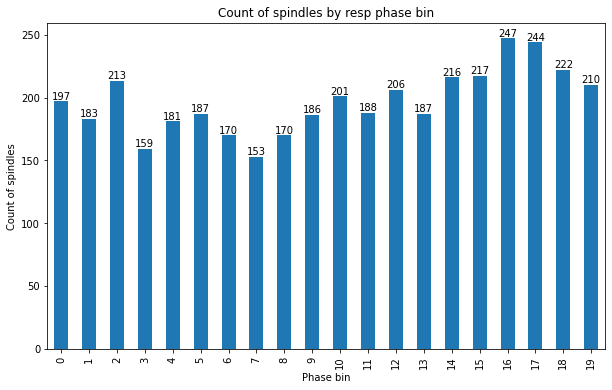

In [84]:
phase_count = count_spindles_phase_resp(nbins = 20)

In [37]:
df_cycles['cycle_freq'].mean()

0.34948216571468377

In [78]:
def count_spindles_i_e_norm(spindles = spindles, df_cycles = df_cycles, save=False):
    spindles_times = spindles['Peak'].values
    loop = range(df_cycles.shape[0])
    loop = tqdm.tqdm(loop , desc = 'cycle rsp')

    count = []

    for cycle in loop:

        start = df_cycles.loc[cycle,'inspi_time']
        transition = df_cycles.loc[cycle , 'expi_time']
        stop = df_cycles.loc[cycle,'end_time']
        
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < transition:
                count.append('i')
            elif spindle_time >= transition and spindle_time < stop:
                count.append('e')
            else:
                count.append('Nothing in this cycle')
    count_ser = pd.Series(count).value_counts()
    count_norm = pd.DataFrame.from_dict({'i': round(count_ser.loc['i'] / df_cycles['cycle_freq'].mean() , 2) , 'e' : round(count_ser.loc['e'] / (1 - df_cycles['cycle_freq'].mean()), 2)}, orient = 'index')
    if save:
        count_norm.to_excel(f'../presentation/count_i_e_norm.xlsx')
    return count_norm

In [81]:
count_spindles_i_e_norm()

cycle rsp: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 3919/3919 [00:02<00:00, 1396.70it/s]


,0
i,3702.62
e,4062.92


In [55]:
def which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles, save=False):
    spindles_times = spindles['Peak'].values
    loop = range(df_cycles.shape[0])
    loop = tqdm.tqdm(loop , desc = 'cycle rsp')

    count = []

    for cycle in loop:

        start = df_cycles.loc[cycle,'inspi_time']
        stop = df_cycles.loc[cycle,'end_time']
        
        for spindle_time in spindles_times:
            if spindle_time >= start and spindle_time < stop:
                count.append(cycle)
    cycles_with_spindle = pd.Series(count).unique()
    if save:
        np.save('../df_analyse/cycle_spindled', cycles_with_spindle)
    return cycles_with_spindle

In [58]:
which_cycle_find_spindle(spindles = spindles, df_cycles = df_cycles)

cycle rsp: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 3919/3919 [00:01<00:00, 3041.52it/s]


array([  15,   19,   20, ..., 3893, 3908, 3913])